<a href="https://colab.research.google.com/github/agi2019/ppi-gci/blob/main/tutorials/01a%20-%20data%20preparation%20(indicators).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Data preparation – development indicators</center>

Prepared by Omar A. Guerrero (oguerrero@turing.ac.uk, <a href="https://twitter.com/guerrero_oa">@guerrero_oa</a>) Adapted for PPI-GCI project on cybersecurity policy prioritisation

This Simulation is based on tutorial of PPI, and its purpose is to demonstrate how you can prepare a dataset of indicators to be in the best shape for its use with the model. I will pre-process a raw dataset coming from the Global Cybersecurity Index (GCI) dataset from ITU and national cybersecurity policy documents. These dataset is based in Indonesia Score in the GCI Assessment 2020 and 2024, while the value of 2021 - 2023 are derived from interpolation using GCI Score from 2014,2017,2018,2020 and 2024 edition.
<p>The objective of this first step is to show how to normalise and extract the relevant features from these data to calibrate the model of PPI.

## Import the necessary Python libraries to manipulate data

In [13]:
import pandas as pd
import numpy as np
import altair as alt


Select Scenario

In [14]:
#scenario = '_scenario1'
#scenario = '_scenario2'
scenario = '_scenario3'


## Import the raw development indicators

In [15]:
data = pd.read_csv('https://raw.githubusercontent.com/agi2019/ppi-gci/main/tutorials/raw_data'+scenario+'/raw_indicators.csv')

In [16]:
# display the data
data

,Unnamed: 0,seriesCode,sdg,2020,2021,2022,2023,2024,seriesName,bestBound,worstBound,instrumental,invert,color
0,0,gci11_Lonline,11,2.728650,3.423680,3.423680,3.374194,3.423680,Laws on unauthorized online behavior,3.423680,0,1,0,#A21942
1,1,gci11_Lforgery,11,1.872751,2.805590,2.792841,2.678415,2.805590,legislation in force related to computer-relat...,2.805590,0,1,0,#A21942
2,2,gci11_Lolsafety,11,3.176444,3.176444,3.176444,3.176444,3.176444,Laws on online safety,3.176444,0,1,0,#A21942
3,3,gci12_Rpdp,12,1.628493,1.628493,1.628493,1.628493,1.628493,Regulation(s) related to personal data protect...,1.628493,0,1,0,#FF3A21
4,4,gci12_Rprivacy,12,1.183533,1.183533,1.183533,1.183533,1.183533,Regulation(s) related to privacy protection,1.183533,0,1,0,#FF3A21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,58,gci52_Mcapacitydev,52,2.062319,2.062319,2.062319,2.062319,2.062319,Part of a multilateral cybersecurity agreement...,2.062319,0,1,0,#F472D0
59,59,gci53_Mlat,53,3.032386,1.957895,2.393784,2.865904,3.032386,Participate in Mutual Legal Assistance Treatie...,3.032386,0,0,0,#FA6800
60,60,gci54_PPPdomestic,54,3.416127,2.205663,2.696711,3.228577,3.416127,Participate in PPPs on cybersecurity with dome...,3.416127,0,1,0,#6D8764
61,61,gci54_PPPforeign,54,2.304660,1.488031,1.819312,2.178131,2.304660,Participate in PPPs on cybersecurity with fore...,2.304660,0,1,0,#6D8764


As you can see from the previous table, the dataset contains different cybersecurity indicators. While normalising the observations is not a requirement to run PPI, it helps with the calibration. Likewise, it is recommended to invert the direction of those indicators where better outcomes are reflected in lower values. This inversion is recommended to make the analysis easier to interpret.

Next, let me explain the different columns of this dataset:


* <strong>seriesCode</strong>: The code assigned to the indicator. It captures the GCI indicator to which it belongs and the main policy issue that it relates to.
* <strong>sdg</strong>: GCI Pillar in which the indicator is classified..
* <strong>2020...2024</strong>: The value of the indicator in the corresponding year.
* <strong>seriesName</strong>: The complete name of the indicator.
* <strong>bestBound</strong>: The highest value that the indicator can take.
* <strong>worstBound</strong>: The lowest value that the indicator can take.
* <strong>instrumental</strong>: Takes 1 if an indicator is instrumental and 0 if it is collateral.
* <strong>invert</strong>: Takes 1 if it needs to be inverted and 0 if not.
* <strong>color</strong>: The colour code of the SDG to which the indicator belongs.

Some of the columns in this dataset may seem odd to the user, as they reflect concepts explained in the book and other prior publications. Let me briefly explain these terms for those not fully acquainted with PPI.

### Technical bounds
The <strong>bestBound</strong> and <strong>worstBound</strong> are the so-called technical or theoretical limits of an indicator. The former determines the highest possible value and the latter the lowest. In this tutorial, they will help me to normalise each indicator between 0 and 1. Sometimes, technical bounds are provided by the data; others, you need to determine them according to prior knowledge or expert advice. I will also normalise the technical bounds (turning them into 1s and 0s) to use them in PPI.

### Instrumental vs collateral indicators
An indicator is considered <strong>instrumental</strong> when there is certainty of the existance of at least one government programme designed to impact it (it does not mean that such programme is effective). Collateral indicators, on the other hand, are those for which there are no expenditure programmes, either because they simply do not exist, or because the indicator is too aggregate for any government to claim that they have a reliable impact through their programmes.

## Normalise values

First, I will normalise the observations between 0 and 1 using the <strong>bestBound</strong> and <strong>worstBound</strong> columns, through the formula

$$ normalisedValue = \frac{observedValue - worstBound}{bestBound - worstBound} .$$

Notice that, to assure that `normalisedValue` is between 0 and 1, I have made sure (manually) that no observation exceeds <strong>bestBound</strong> or <strong>worstBound</strong> (as they are not, strictly speaking, technical bounds).

Next, I invert the direction of those indicators whose better outcomes are expressed through lower values. I do this by applying the formula

$$ invertedValue = 1 - normalisedValue $$

to those indicators with a value of 1 in the column <strong>invert</strong>.

In [17]:
normalised_series = []
years = [column_name for column_name in data.columns if str(column_name).isnumeric()]
for index, row in data.iterrows():
    time_series = row[years].values
    normalised_serie = (time_series - row.worstBound)/(row.bestBound - row.worstBound)
    if row.invert == 1:
        final_serie = 1 - normalised_serie
    else:
        final_serie = normalised_serie
    normalised_series.append( final_serie )

df = pd.DataFrame(normalised_series, columns=years)

## Normalise the theoretical bounds and add the other columns

In [18]:
df['seriesCode'] = data.seriesCode
df['sdg'] = data.sdg
df['minVals'] = np.zeros(len(data))
df['maxVals'] = np.ones(len(data))
df['instrumental'] = data.instrumental
df['seriesName'] = data.seriesName
df['color'] = data.color

## Building new variables

Now, I will build a couple of additional variables that are necessary to calibrate and run PPI:

* <strong>I0</strong>: The initial values of the indicators in the sample period.
* <strong>IF</strong>: The final values of the indicators in the sample period.
* <strong>successRates</strong>: The number of times that an indicator improved as a fraction of the number of times it changed in the sample period.

Parameter <strong>I0</strong> provides the initial condition of each indicator when running retrospective simulations. This means that <strong>I0</strong> is necessary for calibration. However, once calibrated, <strong>I0</strong> can be changed to perform prospective simulations.

The levels in <strong>IF</strong> correspond to the last value that each indicator achieved in the sample period. Together with <strong>I0</strong>, these vectors help building the trend feature that PPI will attempt to calibrate. Nevertheless, it is recommended to manually check <strong>IF</strong>, as it could be the case that the last value in the time series was the result of an exogenous shock or idiosyncratic factors (it would exhibit a behaviour that is not consistent with the indicator's historical pattern). If that was the case, it is advised to adjust the last value of the time series in an attempt to better represent the trend component of the indicator, for example, one could fit a regression model or a Gaussian process and correct the last observation using the predicted value. In these tutorials, I will not make such verification, and directly use the final values reported in the dataset.

The column <strong>successRates</strong> is used to calibrate PPI by minimising a second type of error that relates to a different feature of the data. The idea is that the model endogenously produces a success rate that, on average, matches the empirical one. This means that one needs to compute, from the data, how often each indicator improves, in relation to the number of attempts to improve. For this dataset, in which I have more than 20 observation per time series, I can simply count how many times an indicator improved from one period to another, and divide that amount by the number times that the indicator changed.


### Success rates for short time series

If a time series is too short, the above calculation may be problematic as it would not be representative of the average success rate. In that case, one could deploy non-linear data imputation methods such as Gaussian processes to augment the series. Alternatively, if there are multiple indicators that belong to the same policy dimension, a reasonable strategy could be to group them and consider that they are realisations of very similar policies. Thus, the sample success rate could be calculated by pulling the changes of all these indicators. In this strategy, the success rate would be the same for the indicators belonging to the same group, but each indicator would still preserve its own trend feature. The same grouping strategy could apply if it is reasonable to assume that multiple geographical units (e.g., countries, regions, states, etc.) have similar policies on the same policy dimension. Finally, all these straegies could be combined together, as I have done in https://doi.org/10.1007/s11625-022-01095-1 using a multi-output Gaussian process approach called `mogptk` (https://doi.org/10.1016/j.neucom.2020.09.085).

If you do not think that the assumptions behind the aforementioned techniques are reasonable, then the best choice is always to remove these indicators from your dataset, and explude them from your study.

In [19]:
# add new columns
df['I0'] = df[years[0]]
df['IF'] = df[years[-1]]
successRates = np.sum(df[years].values[:,1::] > df[years].values[:,0:-1], axis=1)/(len(years)-1)
#successRates = np.sum(df[years].values[:, 1:] - df[years].values[:, :-1], axis=1)

# if a success rate is 0 or 1, it is recommended to replace them by a very low or high value as
# zeros and ones are usually an artefact of lacking data on enough policy trials in the indicator
successRates[successRates==0] = .05
successRates[successRates==1] = .95
df['successRates'] = successRates

In [20]:
successRates

array([0.4 , 0.4 , 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.4 , 0.05,
       0.8 , 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.4 , 0.4 , 0.8 , 0.6 ,
       0.6 , 0.6 , 0.6 , 0.6 , 0.4 , 0.4 , 0.4 , 0.6 , 0.6 , 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.8 ,
       0.8 , 0.4 , 0.05, 0.05, 0.05, 0.8 , 0.6 , 0.6 , 0.05, 0.05, 0.05,
       0.05, 0.4 , 0.05, 0.05, 0.6 , 0.6 , 0.6 , 0.2 ])

## Development gaps

To capture the trend component of indicators, PPI measures an error with respect to the development gap shown in the historical data. That is, the difference between the final and initial values. It is important to make sure that these two values are different from each other, i.e. that the development gap is non-zero, otherwise the calibration method will not be able to define the gap error (and will throw and exception). Thus, here I will introduce a slight modification to the final values to assure that I get non-zero gaps.

In [21]:
df.loc[df.I0==df.IF, 'IF'] = df.loc[df.I0==df.IF, 'IF']*1.05

## Governance parameters

PPI takes into account the role of public governance. First, it considers the quality of the monitoring mechanisms of the central authority to spot inefficiencies. Second, it accounts for the quality of the rule of law to exercise corrective measures when an inefficiency is discovered. In PPI's empirical applications, these parameters come from public indicators from the World Bank's Worldwide Governance Indicators (https://doi.org/10.1017/S1876404511200046). Their values need to be between 0 and 1, and they can be specific to each indicator if the user has information about how heterogeneous is public governance across different policy issues.

For the parameters we wil take Indonesian data in latest publication on World Bank's Worldwide Governance Indicators. Note that these parameters only affect (directly) the instrumental indicators. Thus, if you assign values to the collateral ones, PPI will ignore them.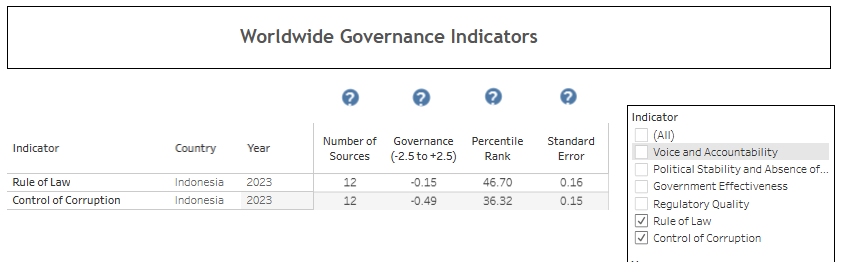

In [22]:
df['qm'] = 0.4670 # quality of monitoring
df['rl'] = 0.3632 # quality of the rule of law

Trend of indicators

In [25]:

# Ubah dataframe ke format long
df_melted = df.melt(
    id_vars=['seriesCode'],
    value_vars=['2020', '2021', '2022', '2023', '2024'],
    var_name='year',
    value_name='value'
)

# Konversi tahun ke integer agar urut
df_melted['year'] = df_melted['year'].astype(int)
df_melted['seriesCode'] = df_melted['seriesCode'].astype(str)

# Buat grafik tanpa selector
chart = alt.Chart(df_melted).mark_line(interpolate='monotone', strokeWidth=3).encode(
    x=alt.X('year:O', title='Year', axis=alt.Axis(labelAngle=0, labelPadding=15)),
    y=alt.Y('value:Q', title='Value'),
    color=alt.Color('seriesCode:N', legend=alt.Legend(title="Series Code")),
    tooltip=['seriesCode', 'year', 'value']
).properties(
    width=700,
    height=600,
    title='Trend per Series Code (2020–2024)'
)

chart

alt.Chart(...)

Visualization with selector



In [29]:

# Ubah dataframe ke format long
df_melted = df.melt(
    id_vars=['seriesCode'],
    value_vars=['2020', '2021', '2022', '2023', '2024'],
    var_name='year',
    value_name='value'
)

# Konversi tahun ke integer agar urut
df_melted['year'] = df_melted['year'].astype(int)
df_melted['seriesCode'] = df_melted['seriesCode'].astype(str)

# Buat dropdown selector untuk memilih satu seriesCode
selector = alt.param(
    name='series_selector',
    bind=alt.binding_select(options=sorted(df_melted['seriesCode'].unique()), name='Select Series: '),
    value=sorted(df_melted['seriesCode'].unique())[0]  # inisialisasi nilai awal
)

# Buat grafik utama
chart = alt.Chart(df_melted).mark_line(interpolate='monotone', strokeWidth=3).encode(
    x=alt.X('year:O', title='Year', axis=alt.Axis(labelAngle=0, labelPadding=15)),
    y=alt.Y('value:Q', title='Value'),
    color=alt.Color('seriesCode:N', legend=alt.Legend(title="Series Code")),
    tooltip=['seriesCode', 'year', 'value'],
    opacity=alt.condition(
        f"datum.seriesCode === {selector.name}",
        alt.value(1),  # tampil penuh jika cocok
        alt.value(0.25)  # redup jika tidak cocok
    )
).add_params(
    selector
).properties(
    width=700,
    height=600,
    title='Interactive Curved Line Chart: Trends per Indicator (2014–2018)'
)

chart

alt.Chart(...)

## Export data

Now the data is ready to be exported for its use with PPI

In [24]:
df.to_csv('data_indicators.csv', index=False)